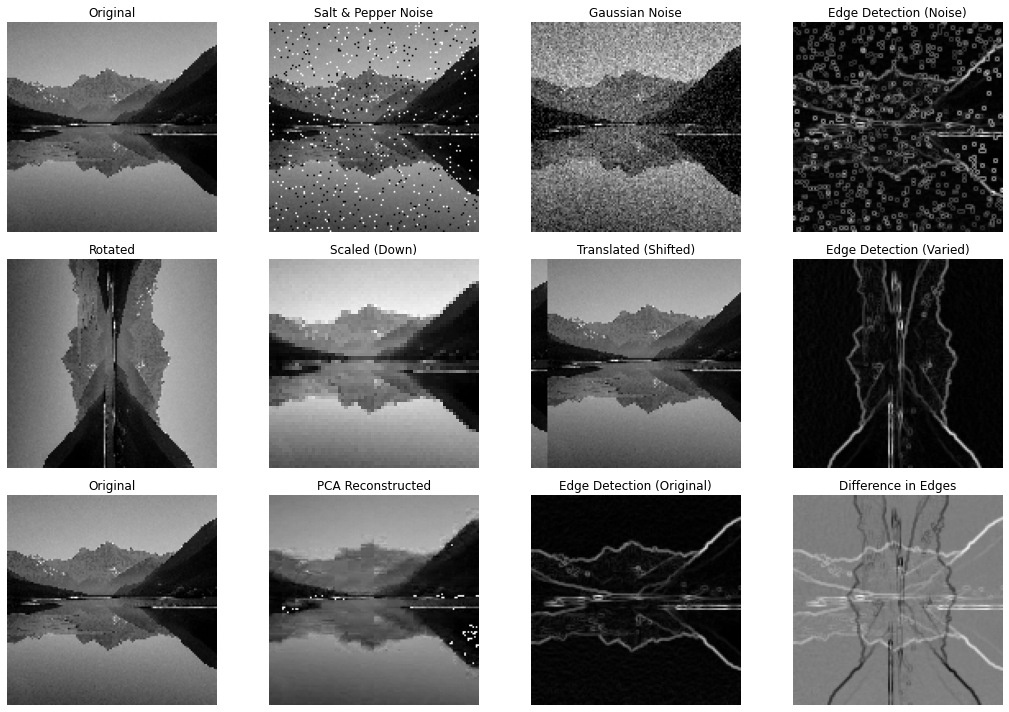

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import random_noise
from skimage.filters import sobel
from sklearn.decomposition import PCA

# Load and preprocess image
image_path = r"C:\Users\Student\Documents\Img processing\image.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if image is None:
    raise FileNotFoundError(f"Image not found at {image_path}")

image = cv2.resize(image, (128, 128))  # Resize for consistency

# Simulating Noise
salt_pepper_noise = random_noise(image, mode='s&p', amount=0.05)
gaussian_noise = random_noise(image, mode='gaussian', var=0.01)

# Convert noise images to uint8 format
salt_pepper_noise = (255 * salt_pepper_noise).astype(np.uint8)
gaussian_noise = (255 * gaussian_noise).astype(np.uint8)

# Simulating Variability
rotated = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
scaled = cv2.resize(image, (64, 64))  # Downscaling
translated = np.roll(image, shift=10, axis=1)  # Horizontal shift

# Fixing PCA issue: Treat 8x8 patches as samples instead of flattening the whole image
patch_size = 8  # Split image into 8x8 patches
patches = [
    image[i:i+patch_size, j:j+patch_size].flatten()
    for i in range(0, 128, patch_size) 
    for j in range(0, 128, patch_size)
]
patches = np.array(patches)  # Convert list to NumPy array

# Apply PCA on patches
pca = PCA(n_components=10)  # Reduce each patch to 10 features
patches_pca = pca.fit_transform(patches)
patches_reconstructed = pca.inverse_transform(patches_pca)

# Reconstruct Image from Patches
image_pca_reconstructed = np.zeros_like(image)
index = 0
for i in range(0, 128, patch_size):
    for j in range(0, 128, patch_size):
        image_pca_reconstructed[i:i+patch_size, j:j+patch_size] = patches_reconstructed[index].reshape(patch_size, patch_size)
        index += 1

# Feature Extraction
edges_original = sobel(image)
edges_noisy = sobel(salt_pepper_noise)
edges_varied = sobel(rotated)

# Display Results
fig, axes = plt.subplots(3, 4, figsize=(15, 10))

# Original and Noisy Images
axes[0, 0].imshow(image, cmap='gray'); axes[0, 0].set_title("Original")
axes[0, 1].imshow(salt_pepper_noise, cmap='gray'); axes[0, 1].set_title("Salt & Pepper Noise")
axes[0, 2].imshow(gaussian_noise, cmap='gray'); axes[0, 2].set_title("Gaussian Noise")
axes[0, 3].imshow(edges_noisy, cmap='gray'); axes[0, 3].set_title("Edge Detection (Noise)")

# Variability Simulations
axes[1, 0].imshow(rotated, cmap='gray'); axes[1, 0].set_title("Rotated")
axes[1, 1].imshow(scaled, cmap='gray'); axes[1, 1].set_title("Scaled (Down)")
axes[1, 2].imshow(translated, cmap='gray'); axes[1, 2].set_title("Translated (Shifted)")
axes[1, 3].imshow(edges_varied, cmap='gray'); axes[1, 3].set_title("Edge Detection (Varied)")

# Dimensionality Reduction (Fixed)
axes[2, 0].imshow(image, cmap='gray'); axes[2, 0].set_title("Original")
axes[2, 1].imshow(image_pca_reconstructed, cmap='gray'); axes[2, 1].set_title("PCA Reconstructed")
axes[2, 2].imshow(edges_original, cmap='gray'); axes[2, 2].set_title("Edge Detection (Original)")
axes[2, 3].imshow(edges_original - edges_varied, cmap='gray'); axes[2, 3].set_title("Difference in Edges")

for ax in axes.flatten():
    ax.axis('off')

plt.tight_layout()
plt.show()
